In [521]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [522]:
print(tf.__version__)

2.10.0


In [523]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [524]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame, feat = None):
    if feat is None:
        count_vectorizer = CountVectorizer(binary=True)
    else:
        count_vectorizer = CountVectorizer(binary=True, vocabulary=feat)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [525]:
from sklearn.feature_selection import SelectKBest, chi2
def select_k_best_features(feature_set, target_values, fraction, feature_list):
    select_bestselect_best = SelectKBest(score_func=chi2, k = int(len(feature_list)*fraction))
    select_bestselect_best.fit(feature_set,target_values)
    mask = select_bestselect_best.get_support()
    k_best_featurs = feature_list[mask]
    return k_best_featurs

In [526]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .50)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [527]:
def createDf(data):
    pd_df = pd.DataFrame(data)
    return pd_df
def addColumn(copy_to, copy_from ,cname):
    copy_to[cname] = copy_from[cname]
    return copy_to

In [528]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']
active_train_df = createDf(active_train)
active_binding_train_df = createDf(active_binding_train)
active_train_df = addColumn(active_train_df, active_binding_train_df, 'binding')
not_active_train_df = createDf(not_active_train)
not_active_binding_train_df = createDf(not_active_binding_train)
not_active_train_df = addColumn(not_active_train_df, not_active_binding_train_df, 'binding')
train_df = pd.concat([active_train_df, not_active_train_df]).reset_index()
train_df = train_df.drop('index', axis=1)
print(train_df.binding.value_counts())
test_df = pd.concat([active_test_df, not_active_test_df]).reset_index()
test_df = test_df.drop('index', axis=1)
print(test_df.binding.value_counts())
from imblearn.over_sampling import RandomOverSampler, SMOTE




0    649
1     39
Name: binding, dtype: int64
0    73
1    39
Name: binding, dtype: int64


In [529]:
sampler = RandomOverSampler(sampling_strategy=1)
x_sampled, y_sampled = sampler.fit_resample(np.array(train_df.sequence).reshape(-1, 1), train_df.binding)

final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

1    649
0    649
Name: binding, dtype: int64
0    73
1    39
Name: binding, dtype: int64


In [530]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [531]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
features = select_k_best_features(training_split,train_result,.30,vectorizer_best.get_feature_names_out())

In [532]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence,features)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [533]:
# smote = SMOTE(random_state=42)
# x, y = smote.fit_resample(training_split, train_result)
# training_split = x
# train_result = y
# print(training_split.shape)
# print(test_split.shape)

In [534]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [535]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [536]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    tn, fp, fn, tp = confusion_matrix(test_res, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = (2 * precision * recall) / (precision + recall)
    print(score)
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [537]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(4 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return np.array(new_train_data), np.array(new_train_res)

In [637]:
def resample(train_data, train_res, weights):
    size = len(train_data)
    indexes = np.random.choice(int(size), int( .42 * size), replace=True, p=weights)
    new_train_data = []
    new_train_res = []
    for index in indexes:
         new_train_data.append(train_data[index])
         new_train_res.append(train_res[index])
    return np.array(new_train_data), np.array(new_train_res)

In [638]:
class EarlyStoppingMonitor(tf.keras.callbacks.Callback):
    def __init__(self):
        super(EarlyStoppingMonitor, self).__init__()
        self.f1_train = None
        self.f1_test = None
        self.prevous = None
        self.count =0

    def on_epoch_end(self, epoch, logs=None):
        current_train_precision = logs.get('precision')
        current_train_recall= logs.get('recall')

        if current_train_precision==0 or current_train_recall==0:
            print("**** Waring: precision recall zero avoid exception ****")
            return
        self.f1_train = (2*current_train_precision*current_train_recall) / (current_train_precision+current_train_recall)
        if self.prevous == None:
            self.prevous = self.f1_train
        if self.prevous == self.f1_train:
            self.count += 1
        else:
            self.prevous = self.f1_train
            self.count = 0
        if self.count == 5:
            self.model.stop_training = True
            print('\n\n******* No improvements *******')
        if current_train_recall > .55:
            # self.count += 1
            # if self.count >4:
            self.model.stop_training = True
            print('\n\n******* Stoping on Defined Thresold *******')
            print('F1 TRAINING: ', self.f1_train)
            print('Recall TRAINING: ', current_train_recall)

    def on_train_end(self, logs=None):
        if self.model.stop_training:
            print("\n\n\n****** Early Stopping *******")

In [639]:
def createBaseModel():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(training_split.shape[-1],)),
        tf.keras.layers.Dense(2, activation='relu',kernel_regularizer=tf.keras.regularizers.L1(.025)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
    ]

    model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(), metrics=METRICS, optimizer='adam')

    return model

In [640]:
ensemble_size = 12
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        print(" =========== iteration ===========>:", i )
        train_data, train_res = resample(training_split, train_result, weights)
        model = createBaseModel()
        num_epochs = 60
        print( "bfore traning: ", ((sum(train_res)/len(train_res)))*100)
        history = model.fit(train_data, train_res,
                    epochs= num_epochs,
                    batch_size=70,
                    callbacks=[EarlyStoppingMonitor()])
        predicted_result = model.predict(training_split)
        predicted_result = [1 if i>=.5 else 0 for i in predicted_result ]
        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = .0001 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(model)
        weights = updateWeight(error_indexes, weights, amount_of_say)


In [641]:
# plt.plot(initial_weight)
boosting(initial_weight)

 =========== iteration ===========>: 0
bfore traning:  48.9908256880734
Epoch 1/60


2022-11-13 17:16:35.186217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 6.3610 - tp: 154.0000 - fp: 116.0000 - tn: 162.0000 - fn: 113.0000 - precision: 0.5704 - recall: 0.5768

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.573556790871699
Recall TRAINING:  0.5767790079116821
8/8 [==============================] - 8s 667ms/step - loss: 6.3610 - tp: 154.0000 - fp: 116.0000 - tn: 162.0000 - fn: 113.0000 - precision: 0.5704 - recall: 0.5768



****** Early Stopping *******
 1/41 [..............................] - ETA: 6s

2022-11-13 17:16:42.675550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.8118131868131868
0.7889060092449923
error_rate: 0.00016263019318567558
0.999999999999993
 =========== iteration ===========>: 1
bfore traning:  50.45871559633027
Epoch 1/60


2022-11-13 17:16:43.459860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 6.4063 - tp: 203.0000 - fp: 132.0000 - tn: 138.0000 - fn: 72.0000 - precision: 0.6060 - recall: 0.7382

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6655737720680185
Recall TRAINING:  0.7381818294525146
8/8 [==============================] - 7s 561ms/step - loss: 6.4063 - tp: 203.0000 - fp: 132.0000 - tn: 138.0000 - fn: 72.0000 - precision: 0.6060 - recall: 0.7382



****** Early Stopping *******
 5/41 [==>...........................] - ETA: 0s

2022-11-13 17:16:49.928140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.8269105160026127
0.7958397534668721
error_rate: 0.0001573277602179652
1.000000000000007
 =========== iteration ===========>: 2
bfore traning:  51.559633027522935
Epoch 1/60


2022-11-13 17:16:50.709174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 6.4471 - tp: 202.0000 - fp: 192.0000 - tn: 72.0000 - fn: 79.0000 - precision: 0.5127 - recall: 0.7189

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.5985185295863734
Recall TRAINING:  0.7188612222671509
8/8 [==============================] - 7s 579ms/step - loss: 6.4471 - tp: 202.0000 - fp: 192.0000 - tn: 72.0000 - fn: 79.0000 - precision: 0.5127 - recall: 0.7189



****** Early Stopping *******
 1/41 [..............................] - ETA: 6s

2022-11-13 17:16:58.061324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 8ms/step
0.6820217530390275
0.6171032357473035
error_rate: 0.00029509737183581244
0.9999999999999744
 =========== iteration ===========>: 3
bfore traning:  48.80733944954129
Epoch 1/60


2022-11-13 17:16:58.880724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 7s 517ms/step - loss: 6.3569 - tp: 57.0000 - fp: 55.0000 - tn: 224.0000 - fn: 209.0000 - precision: 0.5089 - recall: 0.2143
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 1.9077 - tp: 226.0000 - fp: 75.0000 - tn: 204.0000 - fn: 40.0000 - precision: 0.7508 - recall: 0.8496

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.7971781279106456
Recall TRAINING:  0.8496240973472595
8/8 [==============================] - 1s 135ms/step - loss: 1.9077 - tp: 226.0000 - fp: 75.0000 - tn: 204.0000 - fn: 40.0000 - precision: 0.7508 - recall: 0.8496



****** Early Stopping *******
 8/41 [====>.........................] - ETA: 0s

2022-11-13 17:17:06.892231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.9392185238784371
0.9352850539291218
error_rate: 4.994141382650299e-05
0.9999999999999815
 =========== iteration ===========>: 4
bfore traning:  48.62385321100918
Epoch 1/60


2022-11-13 17:17:07.642580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 7s 581ms/step - loss: 6.4167 - tp: 76.0000 - fp: 88.0000 - tn: 192.0000 - fn: 189.0000 - precision: 0.4634 - recall: 0.2868
Epoch 2/60
8/8 [==============================] - 1s 112ms/step - loss: 1.9166 - tp: 134.0000 - fp: 44.0000 - tn: 236.0000 - fn: 131.0000 - precision: 0.7528 - recall: 0.5057
Epoch 3/60
8/8 [==============================] - 1s 78ms/step - loss: 1.3568 - tp: 98.0000 - fp: 7.0000 - tn: 273.0000 - fn: 167.0000 - precision: 0.9333 - recall: 0.3698
Epoch 4/60
8/8 [==============================] - 1s 73ms/step - loss: 0.7798 - tp: 58.0000 - fp: 0.0000e+00 - tn: 280.0000 - fn: 207.0000 - precision: 1.0000 - recall: 0.2189
Epoch 5/60
8/8 [==============================] - 1s 77ms/step - loss: 0.5747 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 280.0000 - fn: 265.0000 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/60
8/8 [==============================] - 0s 13ms/step - loss: 0.4483 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 280.0000 

2022-11-13 17:17:20.461211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.742857142857143
0.7919876733436055
error_rate: 0.00016014679036514592
0.9999999999999735
 =========== iteration ===========>: 5
bfore traning:  49.357798165137616
Epoch 1/60


2022-11-13 17:17:21.329791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 7s 520ms/step - loss: 6.3950 - tp: 137.0000 - fp: 79.0000 - tn: 197.0000 - fn: 132.0000 - precision: 0.6343 - recall: 0.5093
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 1.9166 - tp: 254.0000 - fp: 57.0000 - tn: 219.0000 - fn: 15.0000 - precision: 0.8167 - recall: 0.9442

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8758620501751706
Recall TRAINING:  0.9442378878593445
8/8 [==============================] - 1s 165ms/step - loss: 1.9166 - tp: 254.0000 - fp: 57.0000 - tn: 219.0000 - fn: 15.0000 - precision: 0.8167 - recall: 0.9442



****** Early Stopping *******
 8/41 [====>.........................] - ETA: 0s

2022-11-13 17:17:29.732179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.9446870451237264
0.9414483821263482
error_rate: 4.520141433558646e-05
0.9999999999999992
 =========== iteration ===========>: 6
bfore traning:  48.07339449541285
Epoch 1/60


2022-11-13 17:17:30.456071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 6.3706 - tp: 189.0000 - fp: 210.0000 - tn: 73.0000 - fn: 73.0000 - precision: 0.4737 - recall: 0.7214

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.5718608215142214
Recall TRAINING:  0.7213740348815918
8/8 [==============================] - 7s 594ms/step - loss: 6.3706 - tp: 189.0000 - fp: 210.0000 - tn: 73.0000 - fn: 73.0000 - precision: 0.4737 - recall: 0.7214



****** Early Stopping *******


2022-11-13 17:17:37.119768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 7ms/step
0.6458616010854817
0.5978428351309707
error_rate: 0.0003099564757538337
0.9999999999999916
 =========== iteration ===========>: 7
bfore traning:  49.54128440366973
Epoch 1/60


2022-11-13 17:17:38.014867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 6.4427 - tp: 216.0000 - fp: 177.0000 - tn: 98.0000 - fn: 54.0000 - precision: 0.5496 - recall: 0.8000

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.6515837025308984
Recall TRAINING:  0.800000011920929
8/8 [==============================] - 7s 586ms/step - loss: 6.4427 - tp: 216.0000 - fp: 177.0000 - tn: 98.0000 - fn: 54.0000 - precision: 0.5496 - recall: 0.8000



****** Early Stopping *******


2022-11-13 17:17:44.510595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.7816901408450705
0.7611710323574731
error_rate: 0.00018416980220640507
1.000000000000012
 =========== iteration ===========>: 8
bfore traning:  52.84403669724771
Epoch 1/60


2022-11-13 17:17:45.349879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 7s 622ms/step - loss: 6.3980 - tp: 112.0000 - fp: 60.0000 - tn: 197.0000 - fn: 176.0000 - precision: 0.6512 - recall: 0.3889
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 1.9247 - tp: 229.0000 - fp: 36.0000 - tn: 221.0000 - fn: 59.0000 - precision: 0.8642 - recall: 0.7951

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8282097675814598
Recall TRAINING:  0.7951388955116272
8/8 [==============================] - 0s 64ms/step - loss: 1.9247 - tp: 229.0000 - fp: 36.0000 - tn: 221.0000 - fn: 59.0000 - precision: 0.8642 - recall: 0.7951



****** Early Stopping *******
 1/41 [..............................] - ETA: 7s

2022-11-13 17:17:53.090867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.874675885911841
0.8882896764252697
error_rate: 8.593410324945112e-05
1.0
 =========== iteration ===========>: 9
bfore traning:  46.42201834862386
Epoch 1/60


2022-11-13 17:17:53.884590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 8s 581ms/step - loss: 6.3863 - tp: 107.0000 - fp: 107.0000 - tn: 185.0000 - fn: 146.0000 - precision: 0.5000 - recall: 0.4229
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 1.9125 - tp: 240.0000 - fp: 32.0000 - tn: 260.0000 - fn: 13.0000 - precision: 0.8824 - recall: 0.9486

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9142857287737788
Recall TRAINING:  0.948616623878479
8/8 [==============================] - 1s 119ms/step - loss: 1.9125 - tp: 240.0000 - fp: 32.0000 - tn: 260.0000 - fn: 13.0000 - precision: 0.8824 - recall: 0.9486



****** Early Stopping *******
 5/41 [==>...........................] - ETA: 0s

2022-11-13 17:18:02.299789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 7ms/step
0.9878234398782344
0.987673343605547
error_rate: 9.573378116233056e-06
1.0000000000000115
 =========== iteration ===========>: 10
bfore traning:  48.80733944954129
Epoch 1/60


2022-11-13 17:18:03.086589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 7s 525ms/step - loss: 6.4016 - tp: 109.0000 - fp: 53.0000 - tn: 226.0000 - fn: 157.0000 - precision: 0.6728 - recall: 0.4098
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 1.9305 - tp: 221.0000 - fp: 20.0000 - tn: 259.0000 - fn: 45.0000 - precision: 0.9170 - recall: 0.8308

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.8717949281051907
Recall TRAINING:  0.8308271169662476
8/8 [==============================] - 0s 57ms/step - loss: 1.9305 - tp: 221.0000 - fp: 20.0000 - tn: 259.0000 - fn: 45.0000 - precision: 0.9170 - recall: 0.8308



****** Early Stopping *******
 8/41 [====>.........................] - ETA: 0s

2022-11-13 17:18:10.016459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 0s 6ms/step
0.8377896613190731
0.8597842835130971
error_rate: 0.00010794474778253309
1.0000000000000075
 =========== iteration ===========>: 11
bfore traning:  46.055045871559635
Epoch 1/60


2022-11-13 17:18:10.762970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 6s 560ms/step - loss: 6.4125 - tp: 113.0000 - fp: 97.0000 - tn: 197.0000 - fn: 138.0000 - precision: 0.5381 - recall: 0.4502
Epoch 2/60
8/8 [==============================] - ETA: 0s - loss: 1.9176 - tp: 237.0000 - fp: 15.0000 - tn: 279.0000 - fn: 14.0000 - precision: 0.9405 - recall: 0.9442

******* Stoping on Defined Thresold *******
F1 TRAINING:  0.9423459775310953
Recall TRAINING:  0.944223165512085
8/8 [==============================] - 1s 139ms/step - loss: 1.9176 - tp: 237.0000 - fp: 15.0000 - tn: 279.0000 - fn: 14.0000 - precision: 0.9405 - recall: 0.9442



****** Early Stopping *******


2022-11-13 17:18:18.156301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 7ms/step
0.9870722433460076
0.9869029275808937
error_rate: 1.0190445440396881e-05
0.9999999999999987


In [642]:
alphas

[0.0008723869044721096,
 0.0008757021943880129,
 0.0008127910041145563,
 0.0009904610020349779,
 0.0008739259563923707,
 0.0010004336978569359,
 0.0008078768666614091,
 0.0008599468201066722,
 0.0009361843858913323,
 0.0011556514851159864,
 0.0009133783105781165,
 0.0011494049807704184]

In [643]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


def repeat(test_split, test_result, start, end):
    mx = 0
    size = 0
    data = []
    f1=[]
    for i in range(start,end):
        data = some_pred(test_split, i)
        tn, fp, fn, tp = confusion_matrix(test_result, data).ravel()
        precision = tp / (tp+ fp)
        recall = tp / (tp+ fn)
        score = (2 * precision * recall) / (precision + recall)
        print(score)
        f1.append(score)
        if mx < score:
            mx = score
            size = i
        print(i)
    print(mx,size)
    return data, f1

# a = ensemble[0].predict(test_split)

def some_pred(test_split, esize):
#     data = []
    k = []
#     for j in range(len(test_split)):
#         pa=0
#         na =0
    for i in range(esize):
        print('*********:', i)
        k.append(ensemble[i].predict([test_split]))
        # if pa >=na:
        #     data.append(1)
        # else:
        #     data.append(0)
    # f1.append(f1_score(test_result, data, average="macro"))
    # acc.append(accuracy_score(test_result, data))
    return k

In [644]:

def majority(data):
    ans =[]
    for i in range(len(data[0])):
        ap = 0
        an = 0
        for e in range(len(data)):
            if data[e][i] >= .5:
                ap += alphas[e]
            else:
                an += alphas[e]
        if ap >= an:
            ans.append(1)
        else:
            ans.append(0)
    return ans


In [645]:
def getf1(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true, predicted).ravel()
    precision = tp / (tp+ fp)
    recall = tp / (tp+ fn)
    score = ( precision , recall, (2*precision*recall)/(precision+recall))
    return score

In [646]:
f1_test = []
acc_test = []
for i in range(1,13):
    data = some_pred(test_split, i)
    ans = majority(data)
    f1_test.append(getf1(test_result, ans))
    acc_test.append(accuracy_score(test_result, ans))

*********: 0


2022-11-13 17:18:23.736161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 51ms/step
*********: 0
4/4 [==============================] - 0s 19ms/step
*********: 1
1/4 [======>.......................] - ETA: 0s

2022-11-13 17:18:24.285364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 57ms/step
*********: 0
4/4 [==============================] - 0s 15ms/step
*********: 1
4/4 [==============================] - 0s 15ms/step
*********: 2
1/4 [======>.......................] - ETA: 0s

2022-11-13 17:18:24.856708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 97ms/step
*********: 0
4/4 [==============================] - 0s 28ms/step
*********: 1
4/4 [==============================] - 0s 2ms/step
*********: 2
4/4 [==============================] - 0s 16ms/step
*********: 3
1/4 [======>.......................] - ETA: 0s

2022-11-13 17:18:25.574489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 58ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 16ms/step
*********: 2
4/4 [==============================] - 0s 16ms/step
*********: 3
4/4 [==============================] - 0s 16ms/step
*********: 4
1/4 [======>.......................] - ETA: 0s

2022-11-13 17:18:26.269158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 44ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 14ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 15ms/step
*********: 5


2022-11-13 17:18:26.920147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 60ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 24ms/step
*********: 2
4/4 [==============================] - 0s 15ms/step
*********: 3
4/4 [==============================] - 0s 37ms/step
*********: 4
4/4 [==============================] - 0s 22ms/step
*********: 5
4/4 [==============================] - 0s 15ms/step
*********: 6


2022-11-13 17:18:28.111275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 51ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 15ms/step
*********: 3
4/4 [==============================] - 0s 2ms/step
*********: 4
4/4 [==============================] - 0s 15ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 25ms/step
*********: 7
1/4 [======>.......................] - ETA: 0s

2022-11-13 17:18:28.986130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 43ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 23ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 25ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 14ms/step
*********: 8
1/4 [======>.......................] - ETA: 0s

2022-11-13 17:18:29.816839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 33ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 4ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 4ms/step
*********: 5
4/4 [==============================] - 0s 14ms/step
*********: 6
4/4 [==============================] - 0s 28ms/step
*********: 7
4/4 [==============================] - 0s 17ms/step
*********: 8
4/4 [==============================] - 0s 14ms/step
*********: 9
1/4 [======>.......................] - ETA: 0s

2022-11-13 17:18:30.766716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 48ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 4ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 3ms/step
*********: 6
4/4 [==============================] - 0s 17ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 27ms/step
*********: 9
4/4 [==============================] - 0s 21ms/step
*********: 10


2022-11-13 17:18:31.818807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 60ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 2ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 2ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 2ms/step
*********: 7
4/4 [==============================] - 0s 3ms/step
*********: 8
4/4 [==============================] - 0s 2ms/step
*********: 9
4/4 [==============================] - 0s 15ms/step
*********: 10
4/4 [==============================] - 0s 23ms/step
*********: 11


2022-11-13 17:18:32.849590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 62ms/step


In [647]:
f1_train = []
acc_train = []
for i in range(1,13):
    data = some_pred(training_split, i)
    ans = majority(data)
    f1_train.append(getf1(train_result, ans))
    acc_train.append(accuracy_score(train_result, ans))
    # ConfusionMatrixDisplay.from_predictions(test_result,ans,cmap='Greens')

*********: 0
41/41 [==============================] - 0s 6ms/step
*********: 0
41/41 [==============================] - 0s 5ms/step
*********: 1
41/41 [==============================] - 0s 6ms/step
*********: 0
41/41 [==============================] - 0s 4ms/step
*********: 1
41/41 [==============================] - 0s 4ms/step
*********: 2
41/41 [==============================] - 0s 7ms/step
*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 5ms/step
*********: 3
41/41 [==============================] - 0s 6ms/step
*********: 0
41/41 [==============================] - 0s 4ms/step
*********: 1
41/41 [==============================] - 0s 4ms/step
*********: 2
41/41 [==============================] - 0s 4ms/step
*********: 3
41/41 [==============================] - 0s 4ms/step
*********: 4
41/41 [==============================] - 0s 8ms/step
*********:

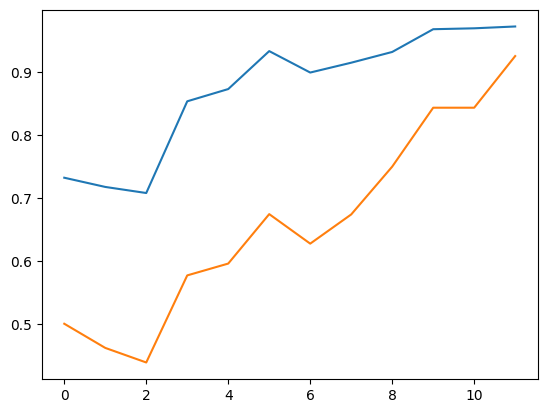

In [648]:

plt.plot([i[0] for i in f1_train])
plt.plot([i[0] for i in f1_test])
# plt.plot()

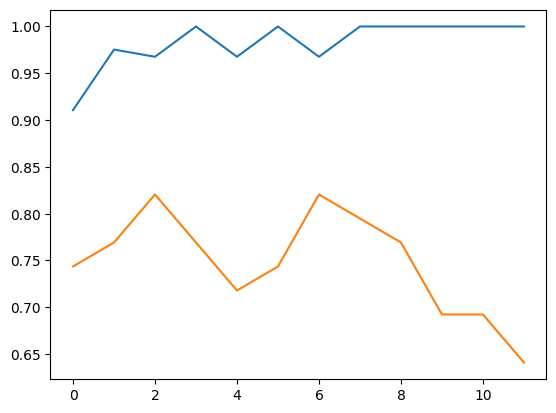

In [649]:
plt.plot([i[1] for i in f1_train])
plt.plot([i[1] for i in f1_test])

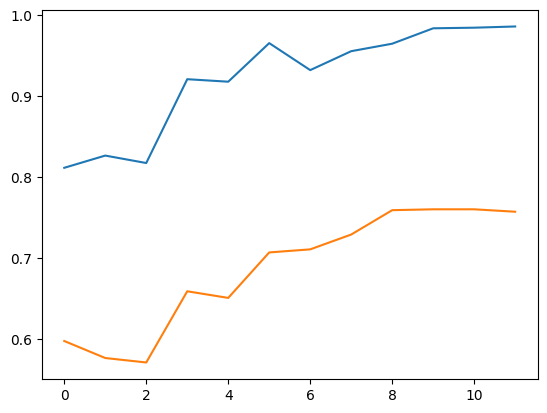

In [650]:
plt.plot([i[2] for i in f1_train])
plt.plot([i[2] for i in f1_test])

*********: 0
41/41 [==============================] - 0s 3ms/step
*********: 1
41/41 [==============================] - 0s 3ms/step
*********: 2
41/41 [==============================] - 0s 3ms/step
*********: 3
41/41 [==============================] - 0s 3ms/step
*********: 4
41/41 [==============================] - 0s 3ms/step
*********: 5
41/41 [==============================] - 0s 3ms/step
*********: 6
41/41 [==============================] - 0s 3ms/step
*********: 7
41/41 [==============================] - 0s 6ms/step
*********: 0
4/4 [==============================] - 0s 3ms/step
*********: 1
4/4 [==============================] - 0s 3ms/step
*********: 2
4/4 [==============================] - 0s 3ms/step
*********: 3
4/4 [==============================] - 0s 3ms/step
*********: 4
4/4 [==============================] - 0s 3ms/step
*********: 5
4/4 [==============================] - 0s 4ms/step
*********: 6
4/4 [==============================] - 0s 3ms/step
*********: 7
4/4 [======

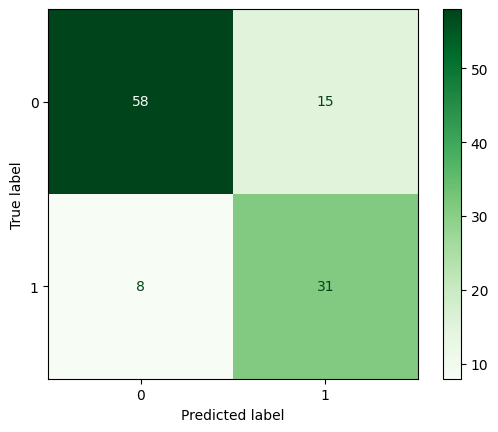

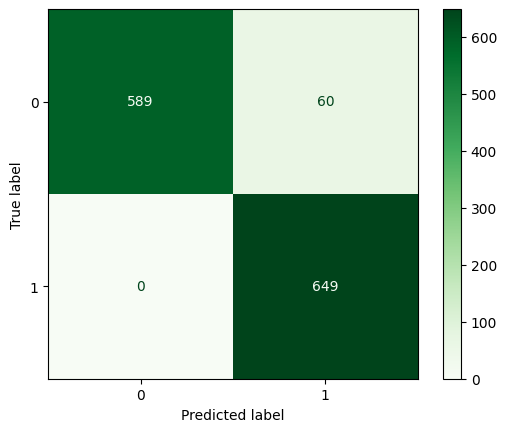

In [652]:
value = 8
data = some_pred(training_split, value)
ans = majority(data)
data = some_pred(test_split, value )
ans1 = majority(data)
ConfusionMatrixDisplay.from_predictions(test_result,ans1,cmap='Greens')
# plt.plot(f1_test)
ConfusionMatrixDisplay.from_predictions(train_result,ans,cmap='Greens')

In [300]:
table_test = pd.read_table('./1663769555_8653905_test.txt', names=['sequence'])
unlabeled_test = vectorizer_best.transform(table_test.sequence).toarray()
predicted_data = majority(some_pred(unlabeled_test, 4))

*********: 0
11/11 [==============================] - 0s 15ms/step
*********: 1
11/11 [==============================] - 0s 7ms/step
*********: 2
11/11 [==============================] - 0s 9ms/step
*********: 3
11/11 [==============================] - 0s 8ms/step


In [304]:
predicted_data
# len(predicted_data)


[1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
